In [1]:
#Importing necessary libraries
import hopsworks
import hsfs
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler  # Import StandardScaler from scikit-learn
import joblib
from prophet import Prophet

load_dotenv()

#Connecting to hopsworks
api_key = os.environ.get('hopsworks_api')
project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()

#Another connection to hopsworks
api_key = os.getenv('hopsworks_api')
connection = hsfs.connection()
fs = connection.get_feature_store()

2024-10-14 19:12:12,995 WARNING: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.

2024-10-14 19:12:12,996 WARNING: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.

2024-10-14 19:12:21,008 WARNING: FutureIncompatibilityWarning: 

This is a future version incompatibility warning from Holidays library v0.58
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates

In [2]:
#Getting the feature view
feature_view = fs.get_feature_view(
    name='amd_stocks_fv',
    version=8
)

In [4]:
df = feature_view.get_batch_data()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


In [5]:
df['date'] = pd.to_datetime(df['date'])


In [6]:
df = df.sort_values('date')

In [7]:
print("Columns in df:")
print(df.columns.tolist())

Columns in df:
['date', 'f_1__open', 'f_2__high', 'f_3__low', 'f_5__volume', 'ticker']


In [8]:
prophet_df = df[['date', 'f_1__open']].rename(columns={'date': 'ds', 'f_1__open': 'y'})

Data range in prophet_df: 1999-11-01 to 2024-10-04
Training period: 2019-10-05 to 2023-10-04
Testing period: 2023-10-05 to 2024-10-04
2024-10-14 19:18:54,639 DEBUG: cmd: where.exe tbb.dll
cwd: None
2024-10-14 19:18:54,700 DEBUG: TBB already found in load path
2024-10-14 19:18:54,717 DEBUG: input tempfile: C:\Users\svjen\AppData\Local\Temp\tmp3oa0d5sp\1fpoek9r.json
2024-10-14 19:18:54,782 DEBUG: input tempfile: C:\Users\svjen\AppData\Local\Temp\tmp3oa0d5sp\x_xirxvv.json
2024-10-14 19:18:54,784 DEBUG: idx 0
2024-10-14 19:18:54,784 DEBUG: running CmdStan, num_threads: None
2024-10-14 19:18:54,785 DEBUG: CmdStan args: ['C:\\Users\\svjen\\OneDrive\\Skrivebord\\Github_repos\\ML_ops_stocks\\.conda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=50086', 'data', 'file=C:\\Users\\svjen\\AppData\\Local\\Temp\\tmp3oa0d5sp\\1fpoek9r.json', 'init=C:\\Users\\svjen\\AppData\\Local\\Temp\\tmp3oa0d5sp\\x_xirxvv.json', 'output', 'file=C:\\Users\\svjen\\AppData\\Local\\Temp\\

19:18:54 - cmdstanpy - INFO - Chain [1] start processing


2024-10-14 19:18:54,786 INFO: Chain [1] start processing


19:18:55 - cmdstanpy - INFO - Chain [1] done processing


2024-10-14 19:18:55,095 INFO: Chain [1] done processing
2024-10-14 19:18:55,206 WARNING: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


Mean Absolute Error (MAE): 108.84622223651132
Root Mean Squared Error (RMSE): 120.44656259196707


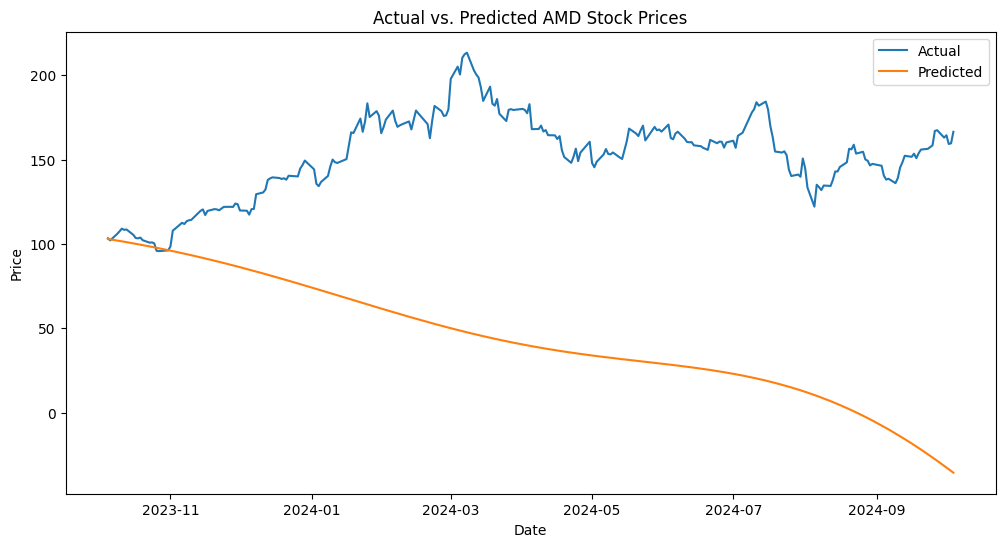

In [12]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Remove timezone information from 'ds' column
prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)

# Ensure the data is sorted by date
prophet_df.sort_values('ds', inplace=True)

# Verify the data range in prophet_df
print("Data range in prophet_df:", prophet_df['ds'].min().date(), "to", prophet_df['ds'].max().date())

# Get the maximum date in the data
max_date = prophet_df['ds'].max()

# Define the testing period (latest year)
test_end_date = max_date
test_start_date = test_end_date - pd.DateOffset(years=1) + pd.DateOffset(days=1)

# Define the training period (4 years prior to testing period)
train_end_date = test_start_date - pd.DateOffset(days=1)
train_start_date = train_end_date - pd.DateOffset(years=4) + pd.DateOffset(days=1)

# Convert date ranges to strings for display
print(f"Training period: {train_start_date.date()} to {train_end_date.date()}")
print(f"Testing period: {test_start_date.date()} to {test_end_date.date()}")

# Split the data
train_df = prophet_df[
    (prophet_df['ds'] >= train_start_date) & (prophet_df['ds'] <= train_end_date)
].copy()

test_df = prophet_df[
    (prophet_df['ds'] >= test_start_date) & (prophet_df['ds'] <= test_end_date)
].copy()

# Check if test_df is not empty
if test_df.empty:
    print("Test DataFrame is empty. Please check the test date range.")
else:
    # Proceed with modeling
    model = Prophet(daily_seasonality=True)
    model.fit(train_df)
    
    # Using the dates from the test set for prediction
    future_dates = test_df[['ds']]
    
    # Generate forecasts
    forecast = model.predict(future_dates)
    
    # Merge the forecast with the actual test data
    forecast_df = forecast[['ds', 'yhat']].set_index('ds')
    actual_df = test_df.set_index('ds')
    
    comparison_df = actual_df.join(forecast_df, how='left').dropna()
    
    # Sort the data by date (ascending order)
    comparison_df.sort_index(inplace=True)
    
    # Compute evaluation metrics
    mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
    rmse = mean_squared_error(comparison_df['y'], comparison_df['yhat'], squared=False)
    
    print(f"\nMean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    
    # Visualize the results
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df.index, comparison_df['y'], label='Actual')
    plt.plot(comparison_df.index, comparison_df['yhat'], label='Predicted')
    plt.legend()
    plt.title('Actual vs. Predicted AMD Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()


In [25]:
import joblib
import hopsworks
import os
import shutil
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Save the trained Prophet model to a file
joblib.dump(model, 'prophet_model.pkl')

# Get your Hopsworks API key (ensure it's set in your environment variables)
api_key = os.environ.get('hopsworks_api')

# Log in to Hopsworks
project = hopsworks.login(api_key_value=api_key)

# Get the model registry
mr = project.get_model_registry()

# Define the model name and metadata
model_name = "ProphetModel"
description = "Prophet model for time series forecasting AMD stock prices"

# Prepare the input example (pandas DataFrame)
input_example = train_df[['ds']].head(1)
input_schema = Schema(input_example)

# Prepare the output example (pandas DataFrame)
output_example = forecast[['yhat']].head(1)
output_schema = Schema(output_example)

# Create the model schema
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Define evaluation metrics
metrics = {
    'MAE': mae,
    'RMSE': rmse
}

# Create the model in the registry
model_registry_entry = mr.python.create_model(
    name=model_name,
    description=description,
    input_example=input_example,
    model_schema=model_schema,
    metrics=metrics
)

# Ensure the model directory exists
model_dir = 'prophet_model_dir'
os.makedirs(model_dir, exist_ok=True)

# Move the model file into the model directory
shutil.move('prophet_model.pkl', os.path.join(model_dir, 'prophet_model.pkl'))

# Save the model artifacts to Hopsworks
model_registry_entry.save(model_dir)

print(f"Model '{model_name}' saved successfully to the Hopsworks Model Registry.")


Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/564374
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/108203 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/23 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/269 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/564374/models/ProphetModel/2
Model 'ProphetModel' saved successfully to the Hopsworks Model Registry.
